In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 64

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalAvgPool1D()(output) for output in layer_outputs[-3:]])
    x = BatchNormalization()(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 64)    384         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 64)    256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 64)    0           batch_normalization_v1[0][0]     
_____________________________________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 64)    384         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_9 (Batch (None, 16000, 64)    256         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 64)    0           batch_normalization_v1_9[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 64)    384         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_22 (Batc (None, 16000, 64)    256         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_22[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9124 - acc: 0.4212
Epoch 00001: val_loss improved from inf to 2.02754, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_BN_3_conv_checkpoint/001-2.0275.hdf5
36805/36805 [==============================] - 55s 2ms/sample - loss: 1.9123 - acc: 0.4212 - val_loss: 2.0275 - val_acc: 0.3611
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4597 - acc: 0.5644
Epoch 00002: val_loss improved from 2.02754 to 1.60478, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_BN_3_conv_checkpoint/002-1.6048.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.4597 - acc: 0.5643 - val_loss: 1.6048 - val_acc: 0.4764
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3139 - acc: 0.6132
Epoch 00003: val_loss improved from 1.60478 to 1.43099, sav

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7830 - acc: 0.7724
Epoch 00027: val_loss did not improve from 0.92873
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7830 - acc: 0.7724 - val_loss: 1.3725 - val_acc: 0.5714
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7774 - acc: 0.7720
Epoch 00028: val_loss did not improve from 0.92873
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7775 - acc: 0.7720 - val_loss: 1.0588 - val_acc: 0.6578
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7661 - acc: 0.7775
Epoch 00029: val_loss did not improve from 0.92873
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7662 - acc: 0.7775 - val_loss: 1.7490 - val_acc: 0.5120
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7601 - acc: 0.7803
Epoch 00030: val_loss did not improve from 0.92873
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6467 - acc: 0.8106
Epoch 00057: val_loss did not improve from 0.92873
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6468 - acc: 0.8106 - val_loss: 1.6058 - val_acc: 0.5416
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6500 - acc: 0.8104
Epoch 00058: val_loss did not improve from 0.92873
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6501 - acc: 0.8104 - val_loss: 1.4574 - val_acc: 0.6382
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6497 - acc: 0.8092
Epoch 00059: val_loss did not improve from 0.92873
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6500 - acc: 0.8091 - val_loss: 1.8601 - val_acc: 0.4910
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6477 - acc: 0.8110
Epoch 00060: val_loss did not improve from 0.92873
36805/36805 [===========

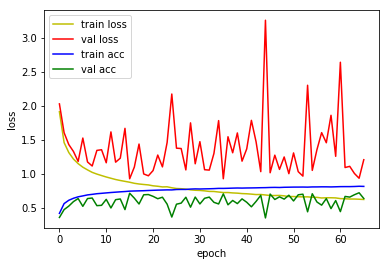

4815/4815 [==============================] - 3s 573us/sample - loss: 1.0163 - acc: 0.6735
Loss: 1.016281790054971 Accuracy: 0.67352027

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7143 - acc: 0.4824
Epoch 00001: val_loss improved from inf to 1.90658, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_BN_4_conv_checkpoint/001-1.9066.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 1.7143 - acc: 0.4824 - val_loss: 1.9066 - val_acc: 0.4095
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2996 - acc: 0.6175
Epoch 00002: val_loss improved from 1.90658 to 1.33820, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_BN_4_conv_checkpoint/002-1.3382.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.2996 - acc: 0.6175 - val_loss: 1.3382 - val_acc: 0.5998
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

36800/36805 [============================>.] - ETA: 0s - loss: 0.5860 - acc: 0.8315
Epoch 00027: val_loss did not improve from 0.81797
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.5861 - acc: 0.8315 - val_loss: 0.9292 - val_acc: 0.7105
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5780 - acc: 0.8347
Epoch 00028: val_loss did not improve from 0.81797
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.5781 - acc: 0.8346 - val_loss: 0.9241 - val_acc: 0.7258
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5718 - acc: 0.8380
Epoch 00029: val_loss improved from 0.81797 to 0.77708, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_BN_4_conv_checkpoint/029-0.7771.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.5717 - acc: 0.8380 - val_loss: 0.7771 - val_acc: 0.7668
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5622 -

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4240 - acc: 0.8790
Epoch 00056: val_loss did not improve from 0.68852
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.4241 - acc: 0.8790 - val_loss: 1.0035 - val_acc: 0.6990
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4201 - acc: 0.8810
Epoch 00057: val_loss did not improve from 0.68852
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.4201 - acc: 0.8810 - val_loss: 0.8787 - val_acc: 0.7503
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4123 - acc: 0.8832
Epoch 00058: val_loss did not improve from 0.68852
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.4123 - acc: 0.8831 - val_loss: 0.7493 - val_acc: 0.7845
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4086 - acc: 0.8826
Epoch 00059: val_loss did not improve from 0.68852
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.3195 - acc: 0.9092
Epoch 00085: val_loss did not improve from 0.60053
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.3198 - acc: 0.9092 - val_loss: 0.6473 - val_acc: 0.8181
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3187 - acc: 0.9087
Epoch 00086: val_loss did not improve from 0.60053
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.3187 - acc: 0.9087 - val_loss: 0.8328 - val_acc: 0.7696
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3163 - acc: 0.9108
Epoch 00087: val_loss did not improve from 0.60053
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.3163 - acc: 0.9108 - val_loss: 0.6249 - val_acc: 0.8155
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3122 - acc: 0.9122
Epoch 00088: val_loss did not improve from 0.60053
36805/36805 [========================

Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2424 - acc: 0.9305
Epoch 00115: val_loss did not improve from 0.60053
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2425 - acc: 0.9305 - val_loss: 0.6942 - val_acc: 0.8148
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2428 - acc: 0.9321
Epoch 00116: val_loss did not improve from 0.60053
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2428 - acc: 0.9321 - val_loss: 1.3791 - val_acc: 0.6688
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2372 - acc: 0.9341
Epoch 00117: val_loss did not improve from 0.60053
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2372 - acc: 0.9341 - val_loss: 0.9591 - val_acc: 0.7375
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2362 - acc: 0.9339
Epoch 00118: val_loss did not improve from 0.60053
36805/36805 [=======

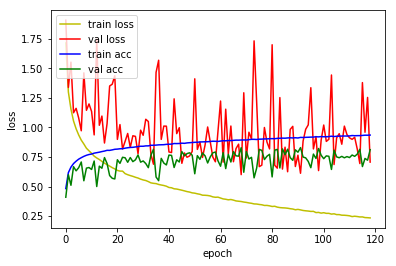

4815/4815 [==============================] - 3s 628us/sample - loss: 0.7190 - acc: 0.7807
Loss: 0.7190013960266906 Accuracy: 0.78068537

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5065 - acc: 0.5438
Epoch 00001: val_loss improved from inf to 1.55653, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_BN_5_conv_checkpoint/001-1.5565.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 1.5065 - acc: 0.5438 - val_loss: 1.5565 - val_acc: 0.5281
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0430 - acc: 0.6977
Epoch 00002: val_loss improved from 1.55653 to 1.07221, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_BN_5_conv_checkpoint/002-1.0722.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 1.0430 - acc: 0.6976 - val_loss: 1.0722 - val_acc: 0.6653
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2658 - acc: 0.9261
Epoch 00026: val_loss improved from 0.39917 to 0.38632, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_BN_5_conv_checkpoint/026-0.3863.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.2661 - acc: 0.9260 - val_loss: 0.3863 - val_acc: 0.9017
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2608 - acc: 0.9276
Epoch 00027: val_loss did not improve from 0.38632
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.2608 - acc: 0.9275 - val_loss: 0.4315 - val_acc: 0.8721
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2545 - acc: 0.9304
Epoch 00028: val_loss did not improve from 0.38632
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.2545 - acc: 0.9303 - val_loss: 0.5039 - val_acc: 0.8505
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1342 - acc: 0.9651
Epoch 00055: val_loss did not improve from 0.32463
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1342 - acc: 0.9651 - val_loss: 0.3638 - val_acc: 0.8940
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1268 - acc: 0.9656
Epoch 00056: val_loss did not improve from 0.32463
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1268 - acc: 0.9655 - val_loss: 0.3845 - val_acc: 0.8970
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1245 - acc: 0.9659
Epoch 00057: val_loss did not improve from 0.32463
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1245 - acc: 0.9658 - val_loss: 0.3601 - val_acc: 0.9057
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1193 - acc: 0.9677
Epoch 00058: val_loss did not improve from 0.32463
36805/36805 [===========

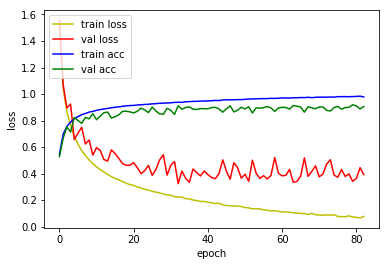

4815/4815 [==============================] - 3s 611us/sample - loss: 0.3889 - acc: 0.8883
Loss: 0.388888766405367 Accuracy: 0.88826585

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2913 - acc: 0.6227
Epoch 00001: val_loss improved from inf to 1.39321, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_BN_6_conv_checkpoint/001-1.3932.hdf5
36805/36805 [==============================] - 63s 2ms/sample - loss: 1.2912 - acc: 0.6227 - val_loss: 1.3932 - val_acc: 0.5847
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7067 - acc: 0.8113
Epoch 00002: val_loss improved from 1.39321 to 0.66946, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_BN_6_conv_checkpoint/002-0.6695.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.7068 - acc: 0.8113 - val_loss: 0.6695 - val_acc: 0.8164
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1029 - acc: 0.9710
Epoch 00025: val_loss did not improve from 0.22031
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1029 - acc: 0.9710 - val_loss: 0.2280 - val_acc: 0.9376
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0908 - acc: 0.9758
Epoch 00026: val_loss did not improve from 0.22031
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0908 - acc: 0.9758 - val_loss: 0.2424 - val_acc: 0.9283
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0861 - acc: 0.9772
Epoch 00027: val_loss did not improve from 0.22031
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0861 - acc: 0.9772 - val_loss: 0.3659 - val_acc: 0.9003
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0854 - acc: 0.9768
Epoch 00028: val_loss improved from 0.22031 to 0.21902, saving model to mod

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0328 - acc: 0.9917
Epoch 00054: val_loss did not improve from 0.20295
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0328 - acc: 0.9917 - val_loss: 0.2607 - val_acc: 0.9352
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0229 - acc: 0.9960
Epoch 00055: val_loss did not improve from 0.20295
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0229 - acc: 0.9960 - val_loss: 0.2808 - val_acc: 0.9234
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.9937
Epoch 00056: val_loss did not improve from 0.20295
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0277 - acc: 0.9937 - val_loss: 0.3417 - val_acc: 0.9178
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0313 - acc: 0.9925
Epoch 00057: val_loss did not improve from 0.20295
36805/36805 [===========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0166 - acc: 0.9962
Epoch 00084: val_loss did not improve from 0.20295
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0166 - acc: 0.9962 - val_loss: 0.2444 - val_acc: 0.9446

1D_CNN_custom_multi_3_GAP_BN_6_conv Model


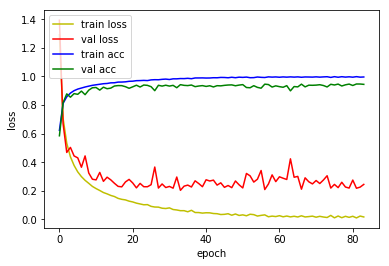

4815/4815 [==============================] - 3s 665us/sample - loss: 0.2738 - acc: 0.9246
Loss: 0.2737547862319312 Accuracy: 0.9246106

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0800 - acc: 0.6823
Epoch 00001: val_loss improved from inf to 1.18024, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_BN_7_conv_checkpoint/001-1.1802.hdf5
36805/36805 [==============================] - 68s 2ms/sample - loss: 1.0800 - acc: 0.6823 - val_loss: 1.1802 - val_acc: 0.6375
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4940 - acc: 0.8646
Epoch 00002: val_loss improved from 1.18024 to 0.44419, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_BN_7_conv_checkpoint/002-0.4442.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.4940 - acc: 0.8647 - val_loss: 0.4442 - val_acc: 0.8765
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9927
Epoch 00026: val_loss did not improve from 0.17205
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0335 - acc: 0.9927 - val_loss: 0.1867 - val_acc: 0.9527
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0246 - acc: 0.9954
Epoch 00027: val_loss did not improve from 0.17205
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0246 - acc: 0.9954 - val_loss: 0.1768 - val_acc: 0.9534
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0250 - acc: 0.9954
Epoch 00028: val_loss did not improve from 0.17205
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0250 - acc: 0.9954 - val_loss: 0.1859 - val_acc: 0.9481
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0305 - acc: 0.9927
Epoch 00029: val_loss did not improve from 0.17205
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0166 - acc: 0.9961
Epoch 00055: val_loss did not improve from 0.17165
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0166 - acc: 0.9961 - val_loss: 0.2020 - val_acc: 0.9513
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0068 - acc: 0.9992
Epoch 00056: val_loss did not improve from 0.17165
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0069 - acc: 0.9991 - val_loss: 0.2206 - val_acc: 0.9483
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0158 - acc: 0.9961
Epoch 00057: val_loss did not improve from 0.17165
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0159 - acc: 0.9960 - val_loss: 0.1898 - val_acc: 0.9546
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0211 - acc: 0.9944
Epoch 00058: val_loss did not improve from 0.17165
36805/36805 [========================

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0047 - acc: 0.9992
Epoch 00084: val_loss did not improve from 0.16313
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0047 - acc: 0.9992 - val_loss: 0.2299 - val_acc: 0.9483
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0076 - acc: 0.9983
Epoch 00085: val_loss did not improve from 0.16313
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0077 - acc: 0.9983 - val_loss: 0.1886 - val_acc: 0.9571
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0141 - acc: 0.9960
Epoch 00086: val_loss did not improve from 0.16313
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0140 - acc: 0.9960 - val_loss: 0.1857 - val_acc: 0.9529
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0037 - acc: 0.9993
Epoch 00087: val_loss did not improve from 0.16313
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0113 - acc: 0.9971
Epoch 00113: val_loss did not improve from 0.16259
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0113 - acc: 0.9971 - val_loss: 0.1920 - val_acc: 0.9576
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0023 - acc: 0.9996
Epoch 00114: val_loss did not improve from 0.16259
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0024 - acc: 0.9996 - val_loss: 0.1787 - val_acc: 0.9618
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0029 - acc: 0.9995
Epoch 00115: val_loss did not improve from 0.16259
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0029 - acc: 0.9995 - val_loss: 0.1664 - val_acc: 0.9630
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.9977
Epoch 00116: val_loss did not improve from 0.16259
36805/36805 [=====================

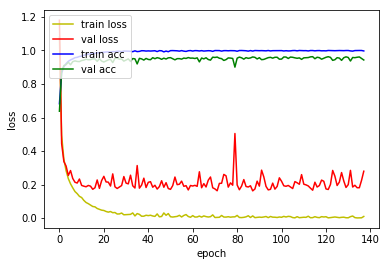

4815/4815 [==============================] - 3s 683us/sample - loss: 0.1975 - acc: 0.9551
Loss: 0.19750091735963146 Accuracy: 0.9551402

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0358 - acc: 0.6884
Epoch 00001: val_loss improved from inf to 0.94102, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_BN_8_conv_checkpoint/001-0.9410.hdf5
36805/36805 [==============================] - 74s 2ms/sample - loss: 1.0357 - acc: 0.6884 - val_loss: 0.9410 - val_acc: 0.7209
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4337 - acc: 0.8742
Epoch 00002: val_loss improved from 0.94102 to 0.36819, saving model to model/checkpoint/1D_CNN_custom_multi_3_GAP_BN_8_conv_checkpoint/002-0.3682.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.4337 - acc: 0.8742 - val_loss: 0.3682 - val_acc: 0.8903
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

36800/36805 [============================>.] - ETA: 0s - loss: 0.0210 - acc: 0.9951
Epoch 00027: val_loss did not improve from 0.15433
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0210 - acc: 0.9951 - val_loss: 0.2527 - val_acc: 0.9324
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0256 - acc: 0.9935
Epoch 00028: val_loss did not improve from 0.15433
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0256 - acc: 0.9935 - val_loss: 0.2264 - val_acc: 0.9411
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0146 - acc: 0.9972
Epoch 00029: val_loss did not improve from 0.15433
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0146 - acc: 0.9972 - val_loss: 0.1983 - val_acc: 0.9483
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0159 - acc: 0.9967
Epoch 00030: val_loss did not improve from 0.15433
36805/36805 [========================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0098 - acc: 0.9975
Epoch 00057: val_loss did not improve from 0.15067
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0098 - acc: 0.9975 - val_loss: 0.2789 - val_acc: 0.9392
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0105 - acc: 0.9974
Epoch 00058: val_loss did not improve from 0.15067
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0105 - acc: 0.9974 - val_loss: 0.1906 - val_acc: 0.9553
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0088 - acc: 0.9981
Epoch 00059: val_loss did not improve from 0.15067
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0088 - acc: 0.9981 - val_loss: 0.2523 - val_acc: 0.9441
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0055 - acc: 0.9987
Epoch 00060: val_loss did not improve from 0.15067
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0052 - acc: 0.9988
Epoch 00086: val_loss did not improve from 0.15014
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0053 - acc: 0.9988 - val_loss: 0.1957 - val_acc: 0.9532
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0098 - acc: 0.9973
Epoch 00087: val_loss did not improve from 0.15014
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0098 - acc: 0.9973 - val_loss: 0.1680 - val_acc: 0.9618
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0052 - acc: 0.9989
Epoch 00088: val_loss did not improve from 0.15014
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0052 - acc: 0.9989 - val_loss: 0.1666 - val_acc: 0.9620
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 0.9995
Epoch 00089: val_loss did not improve from 0.15014
36805/36805 [========================

Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 0.9994
Epoch 00116: val_loss did not improve from 0.15014
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0026 - acc: 0.9994 - val_loss: 0.1907 - val_acc: 0.9597
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0066 - acc: 0.9982
Epoch 00117: val_loss did not improve from 0.15014
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0066 - acc: 0.9982 - val_loss: 0.2156 - val_acc: 0.9562
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0058 - acc: 0.9984
Epoch 00118: val_loss did not improve from 0.15014
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0058 - acc: 0.9984 - val_loss: 0.1756 - val_acc: 0.9592
Epoch 119/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0018 - acc: 0.9996
Epoch 00119: val_loss did not improve from 0.15014
36805/36805 [=======

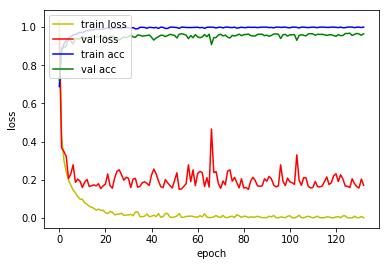

4815/4815 [==============================] - 4s 754us/sample - loss: 0.2388 - acc: 0.9466
Loss: 0.23881585360267746 Accuracy: 0.9466251



In [10]:
base = '1D_CNN_custom_multi_3_GAP_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_3_GAP_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_GAP_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_39[0][0]  
__________________________________________________________________

4815/4815 [==============================] - 4s 737us/sample - loss: 0.7190 - acc: 0.7807
Loss: 0.7190013960266906 Accuracy: 0.78068537

1D_CNN_custom_multi_3_GAP_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)   

4815/4815 [==============================] - 4s 793us/sample - loss: 0.2738 - acc: 0.9246
Loss: 0.2737547862319312 Accuracy: 0.9246106

1D_CNN_custom_multi_3_GAP_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)    

4815/4815 [==============================] - 4s 904us/sample - loss: 0.2388 - acc: 0.9466
Loss: 0.23881585360267746 Accuracy: 0.9466251


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_BN_2'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_GAP_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_39[0][0]  
__________________________________________________________________

4815/4815 [==============================] - 4s 858us/sample - loss: 0.8136 - acc: 0.7784
Loss: 0.8135995472579235 Accuracy: 0.77840084

1D_CNN_custom_multi_3_GAP_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)   

4815/4815 [==============================] - 4s 934us/sample - loss: 0.2757 - acc: 0.9321
Loss: 0.27571433610819585 Accuracy: 0.93208724

1D_CNN_custom_multi_3_GAP_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)  

4815/4815 [==============================] - 5s 970us/sample - loss: 0.2594 - acc: 0.9477
Loss: 0.25942051445967146 Accuracy: 0.94766355
